Использовался следующий датасет: [https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset](https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset)

In [24]:
import os
import sys
from contextlib import contextmanager
from glob import glob

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from loguru import logger
from torch.utils.data import DataLoader, Dataset

DATASET_PATH = "../data/cataract"

In [25]:
@contextmanager
def loglevel(level):
    logger.remove()
    logger.add(sys.stdout, level=level)
    try:
        yield
    finally:
        logger.remove()
        logger.add(sys.stdout, level='DEBUG')

In [26]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CataractDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform_ = transform
        self.images_ = images
        self.labels_ = labels

    def __len__(self):
        return len(self.images_)
         
    

    def __getitem__(self, index):
        image = np.array(Image.open(self.images_[index]).convert('RGB'))

        if not self.transform_:
            return {
                "image": image,
                "label": self.labels_[index]
            }

        return {
            "image": self.transform_(image=image)["image"],
            "label": self.labels_[index]
        }

In [27]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [28]:
immature_path = os.path.join(DATASET_PATH, "immature", "*")
mature_path = os.path.join(DATASET_PATH, "mature", "*")

dataset = CataractDataset(
    images=[*glob(immature_path), *glob(mature_path)],
    labels=[*[0 for _ in range(len(glob(immature_path)))], *[1 for _ in range(len(glob(mature_path)))]],
    transform=transform
)

In [29]:
from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[0.7, 0.2, 0.1])

In [30]:
BATCH_SIZE = 20

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)

# Layers 

In [31]:
import math
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features_ = in_features
        self.out_features_ = out_features
        self.bias_ = bias
        self.weight_ = nn.Parameter(torch.Tensor(out_features, in_features))

        if bias is not None:
            self.bias_ = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset()

    def reset(self):
        nn.init.kaiming_uniform_(self.weight_, a=math.sqrt(5))
        if self.bias_ is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias_, -bound, bound)
    
    def forward(self, input):
        x, y = input.shape

        if y != self.in_features_:
            logger.warn('Invalid input features')
            return 0
        output = input.matmul(self.weight_.t())
        if self.bias_ is not None:
            return output + self.bias_

        return output

In [32]:
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, input):
        return torch.max(torch.zeros_like(input), input)

In [33]:
class CataractNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CataractNN, self).__init__()
        self.fc1_ = LinearLayer(input_size, hidden_size)
        self.relu_ = ReLU()
        self.fc2_ = LinearLayer(hidden_size, output_size)
    
    def forward(self, x):
        for layer in [self.fc1_, self.relu_, self.fc2_]:
            x = layer.forward(x)
        return x

# Обучение

In [73]:
def grad_diff_check(model, data, label, loss_fn, eps=1e-4, num_params_to_check=10):
    data = data.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3)
    
    model.zero_grad()
    loss = loss_fn(model(data), label)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check:
        if param.requires_grad:
            logger.debug(f"Checking gradient correctness for {param_name}") 

            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)
            for i in indices:
                if i >= param_flat.size(0):
                    break

                param_flat[i] += eps
                loss_plus = loss_fn(model(data), label)
                param_flat[i] -= 2 * eps
                loss_minus = loss_fn(model(data), label)
                param_flat[i] += eps

                num_grad = (loss_plus - loss_minus) / (2 * eps)
                diff = torch.abs(num_grad - grad_flat[i]).item()

                if diff > eps:
                    logger.debug(diff)
                    logger.error(f"{param_name}: gradient check failed")
                    return False

    return True
    

In [35]:
def train_epoch(
    model: nn.Module, 
    data_loader,
    optimizer=None,
    criterion=None,
    grad=True,
    mode='train'
):
    if mode == 'train':
        model.train()
    elif mode == 'eval':
        model.eval() # model.train(mode=False)
    else:
        raise ValueError(f"Incorrect value for argument `mode`: {mode}")

    
    loss = 0
    correct = 0
    total = 0

    for data in data_loader:
        image = data["image"]
        label = data["label"]
        image = image.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3)

        output = model(image)

        if criterion:
            ce_loss = criterion(output, label)

        if grad:
            optimizer.zero_grad()
            ce_loss.backward()
            optimizer.step()

        if criterion:
            loss += ce_loss.item()
        _, pred = torch.max(output.data, 1)
        total += label.size(0)
        correct += (pred == label).sum().item() 
    
    if criterion:
        return loss / len(data_loader), correct / total
    return None, correct / total

In [36]:
def train(
    model: nn.Module, 
    optimizer,
    train_loader,
    val_loader,
    num_epochs, 
    params,
):
    criterion = nn.CrossEntropyLoss()
    logger.debug(params)
    logger.debug(list(model.parameters()))
    optimizer = optimizer(model.parameters(), **params)

    train_losses = []
    val_losses = []
    best_accuracy = 0

    logger.info(f"Starting training model {model.__class__.__name__} with optimizer {optimizer.__class__.__name__} and parameters: {params}")
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(
            model=model,
            data_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            mode="train"
        )

        train_losses.append(train_loss)

        with torch.no_grad():
            val_loss, val_accuracy = train_epoch(
                model=model,
                data_loader=val_loader,
                criterion=criterion,
                grad=False,
                mode="eval"
            )

        val_losses.append(val_loss)

        logger.info(
            f"epoch {epoch} finished with results: train loss -- {train_loss}, train accuracy -- {train_accuracy}, val loss -- {val_loss}, val accuracy -- {val_accuracy}"
        )

        best_accuracy = max(best_accuracy, val_accuracy)
        data, label = next(iter(train_loader)).values()
        logger.debug(f"data: {data}")
        logger.debug(f"label: {label}")

        grad_check_result = grad_diff_check(
            model, 
            data,
            label,
            loss_fn=criterion
        )
        logger.debug(f"Gradient check result: {grad_check_result}")

    return {
        "optimizer": optimizer.__class__.__name__,
        "params": params,
        "val_accuracy": best_accuracy,
        "train_losses": train_losses,
        "val_losses": val_losses
    }

In [37]:
def run_train(model, optimizer, num_epochs, params):
    logger.debug(type(model))

    train_results = train(model, optimizer, train_loader, val_loader, num_epochs, params)

    with torch.no_grad():
        _, test_accuracy = train_epoch(
            model=model,
            data_loader=test_loader,
            grad=False,
            mode="eval"
        )

    return {
        "test_accuracy": test_accuracy,
        **train_results
    }

In [38]:
from torch.optim import Adam, RMSprop
from itertools import product
def run_tune(model, num_epochs):
    possible_wd = [0.01, 0.005]
    possible_lr = [0.01, 0.005, 0.001]
    possible_opts = [RMSprop, Adam]

    results = []
    for wd, lr, opt in product(possible_wd, possible_lr, possible_opts):
        tune_results = run_train(
            model=model(input_size=IMAGE_HEIGHT * IMAGE_WIDTH * 3, hidden_size=1024, output_size=20),
            num_epochs=num_epochs,
            params={
                'lr': lr,
                'weight_decay': wd,
            },
            optimizer=opt
        )
        results.append(tune_results)
    return results



In [39]:
with loglevel("INFO"):
    results = run_tune(CataractNN, 20)

In [40]:
def beautify_results(results):
    for i, d in enumerate(results):
        d['epoch'] = list(range(len(d['train_losses'])))
        d['idx'] = i
    
    return pd.concat([pd.json_normalize(d).explode(column=['train_losses', 'val_losses', 'epoch']) for d in results]) 

In [70]:
import seaborn as sns
def plot_train_val_losses(df):
    for idx in range(df['idx'].max() + 1):
        plt.figure(idx)
        plot_df = df[df['idx'] == idx]
        g = sns.lineplot(data=plot_df.melt(id_vars=['epoch'], value_vars=['train_losses', 'val_losses']), x='epoch', y='value', hue='variable');
        g.set(ylabel='loss')
        logger.debug(plot_df['optimizer'].iloc[0])
        logger.debug(plot_df['params.lr'].iloc[0])
        logger.debug(plot_df['params.weight_decay'].iloc[0])
        g.set_title(f"{plot_df['optimizer'].iloc[0]}, {{ lr = {plot_df['params.lr'].iloc[0]}, weight_decay = {plot_df['params.weight_decay'].iloc[0]} }}")

In [42]:
# df = beautify_results(results)

In [43]:
# df.to_csv("results.csv")

In [57]:
df = pd.read_csv("results.csv")

2024-05-31 18:16:47.301 | DEBUG    | __main__:plot_train_val_losses:8 - RMSprop
2024-05-31 18:16:47.302 | DEBUG    | __main__:plot_train_val_losses:9 - 0.01
2024-05-31 18:16:47.303 | DEBUG    | __main__:plot_train_val_losses:10 - 0.01
2024-05-31 18:16:47.339 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.340 | DEBUG    | __main__:plot_train_val_losses:9 - 0.01
2024-05-31 18:16:47.340 | DEBUG    | __main__:plot_train_val_losses:10 - 0.01
2024-05-31 18:16:47.373 | DEBUG    | __main__:plot_train_val_losses:8 - RMSprop
2024-05-31 18:16:47.374 | DEBUG    | __main__:plot_train_val_losses:9 - 0.005
2024-05-31 18:16:47.374 | DEBUG    | __main__:plot_train_val_losses:10 - 0.01
2024-05-31 18:16:47.413 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.414 | DEBUG    | __main__:plot_train_val_losses:9 - 0.005
2024-05-31 18:16:47.414 | DEBUG    | __main__:plot_train_val_losses:10 - 0.01
2024-05-31 18:16:47.452 | DEBUG    | __main__:plot_train_val_los

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

2024-05-31 18:16:47.534 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.535 | DEBUG    | __main__:plot_train_val_losses:9 - 0.001
2024-05-31 18:16:47.536 | DEBUG    | __main__:plot_train_val_losses:10 - 0.01
2024-05-31 18:16:47.576 | DEBUG    | __main__:plot_train_val_losses:8 - RMSprop
2024-05-31 18:16:47.577 | DEBUG    | __main__:plot_train_val_losses:9 - 0.01
2024-05-31 18:16:47.578 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005
2024-05-31 18:16:47.615 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.615 | DEBUG    | __main__:plot_train_val_losses:9 - 0.01
2024-05-31 18:16:47.616 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005
2024-05-31 18:16:47.655 | DEBUG    | __main__:plot_train_val_losses:8 - RMSprop
2024-05-31 18:16:47.656 | DEBUG    | __main__:plot_train_val_losses:9 - 0.005
2024-05-31 18:16:47.656 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005


/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_

2024-05-31 18:16:47.699 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.700 | DEBUG    | __main__:plot_train_val_losses:9 - 0.005
2024-05-31 18:16:47.700 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005
2024-05-31 18:16:47.902 | DEBUG    | __main__:plot_train_val_losses:8 - RMSprop
2024-05-31 18:16:47.903 | DEBUG    | __main__:plot_train_val_losses:9 - 0.001
2024-05-31 18:16:47.903 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005
2024-05-31 18:16:47.942 | DEBUG    | __main__:plot_train_val_losses:8 - Adam
2024-05-31 18:16:47.943 | DEBUG    | __main__:plot_train_val_losses:9 - 0.001
2024-05-31 18:16:47.944 | DEBUG    | __main__:plot_train_val_losses:10 - 0.005


/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

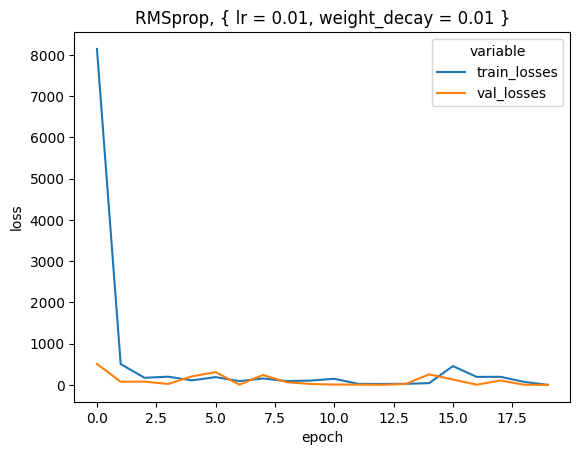

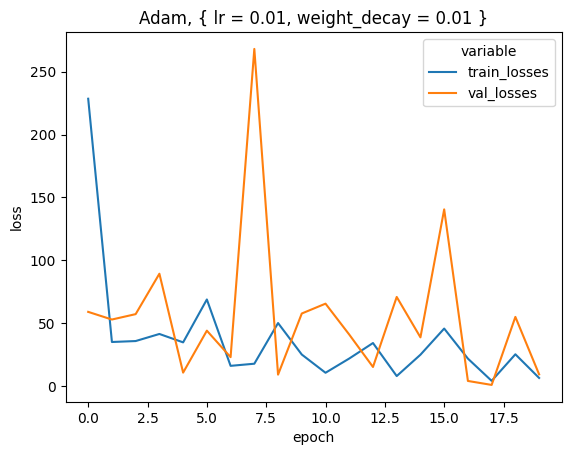

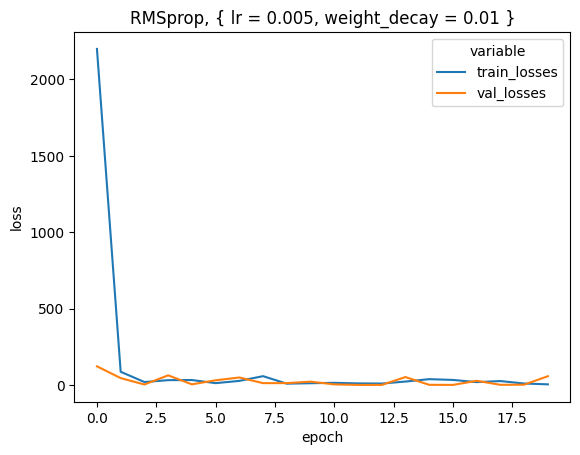

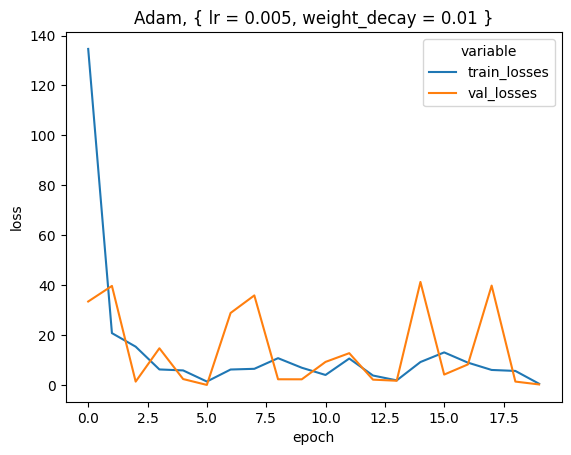

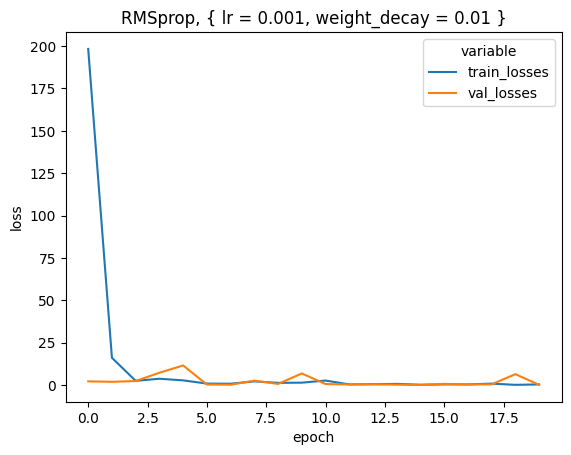

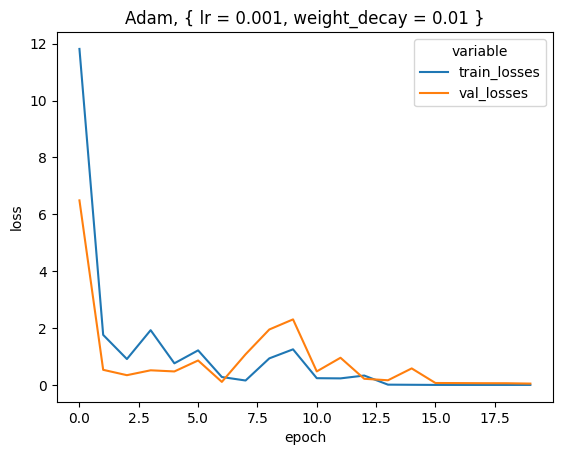

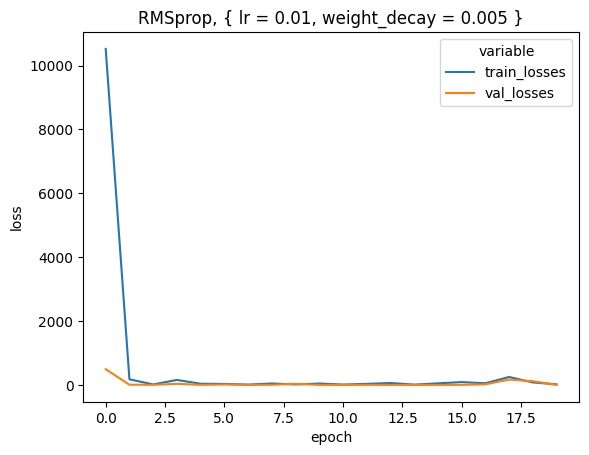

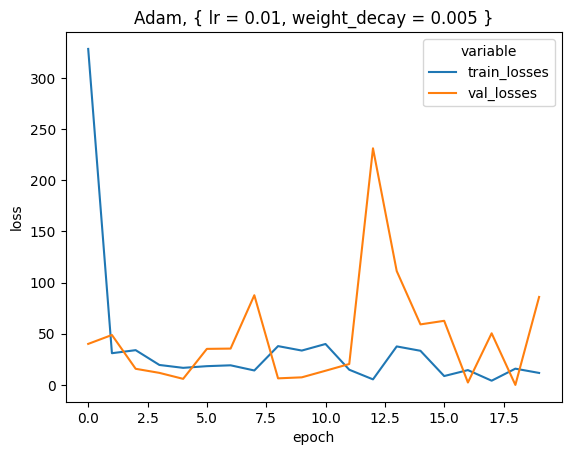

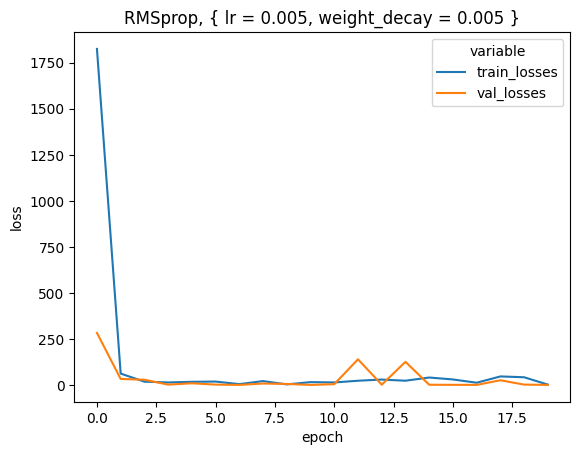

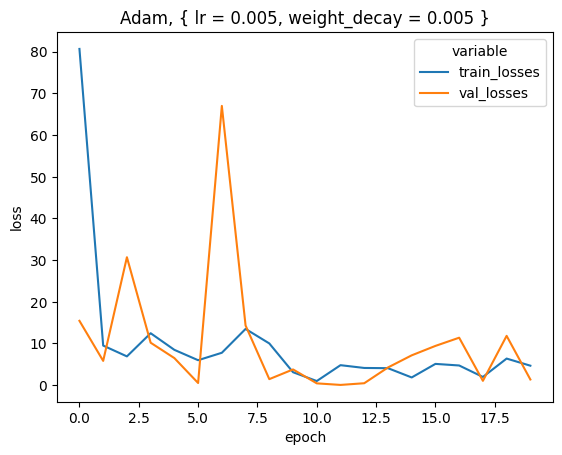

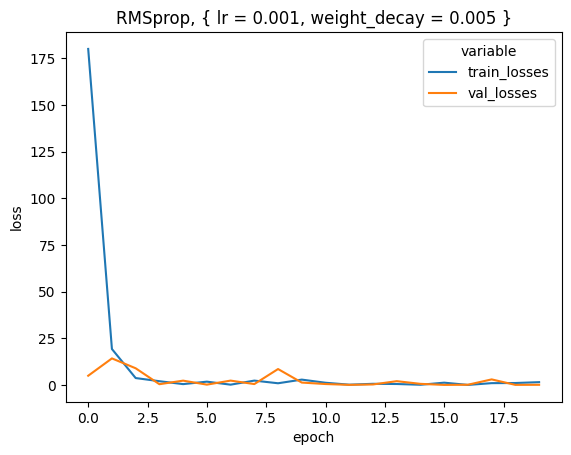

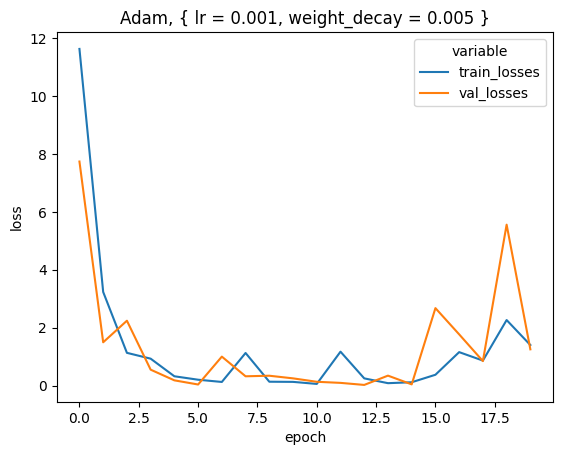

In [71]:
plot_train_val_losses(df)

In [72]:
df.drop_duplicates(subset=['idx'])[['test_accuracy', 'optimizer', 'params.lr', 'params.weight_decay']].sort_values(by='test_accuracy', ascending=False)
# df.drop_duplicates(subset=['idx'])

,test_accuracy,optimizer,params.lr,params.weight_decay
60,1.000000,Adam,0.005,0.010
200,1.000000,RMSprop,0.001,0.005
180,1.000000,Adam,0.005,0.005
80,1.000000,RMSprop,0.001,0.010
0,0.975610,RMSprop,0.010,0.010
120,0.975610,RMSprop,0.010,0.005
100,0.951220,Adam,0.001,0.010
160,0.878049,RMSprop,0.005,0.005
20,0.804878,Adam,0.010,0.010
220,0.780488,Adam,0.001,0.005


# Batch normalization

In [46]:
class CataractBNNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CataractBNNN, self).__init__()
        self.fc1_ = LinearLayer(input_size, hidden_size)
        self.bn1_ = nn.BatchNorm1d(hidden_size)
        self.relu_ = ReLU()
        self.fc2_ = LinearLayer(hidden_size, output_size) 
        self.bn2_ = nn.BatchNorm1d(output_size)
    
    def forward(self, x):
        for layer in [self.fc1_, self.bn1_, self.relu_, self.fc2_, self.bn2_]:
            x = layer.forward(x)
        return x

In [47]:
with loglevel("INFO"):
    bn_results = run_tune(CataractBNNN, 20)

2024-05-31 17:15:20.849 | INFO     | __main__:train:18 - Starting training model CataractBNNN with optimizer RMSprop and parameters: {'lr': 0.01, 'weight_decay': 0.01}
2024-05-31 17:15:24.892 | INFO     | __main__:train:41 - epoch 0 finished with results: train loss -- 2.006855909029643, train accuracy -- 0.6550522648083623, val loss -- 1.6672980785369873, val accuracy -- 0.6341463414634146
2024-05-31 17:15:30.837 | INFO     | __main__:train:41 - epoch 1 finished with results: train loss -- 1.2188316663106282, train accuracy -- 0.8292682926829268, val loss -- 1.468026351928711, val accuracy -- 0.524390243902439
2024-05-31 17:15:36.879 | INFO     | __main__:train:41 - epoch 2 finished with results: train loss -- 0.9540946046511333, train accuracy -- 0.8466898954703833, val loss -- 1.4309180974960327, val accuracy -- 0.6707317073170732
2024-05-31 17:15:43.288 | INFO     | __main__:train:41 - epoch 3 finished with results: train loss -- 0.8018274664878845, train accuracy -- 0.850174216027

In [48]:
df = beautify_results(bn_results)

In [50]:
df.to_csv("bn_results.csv")

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

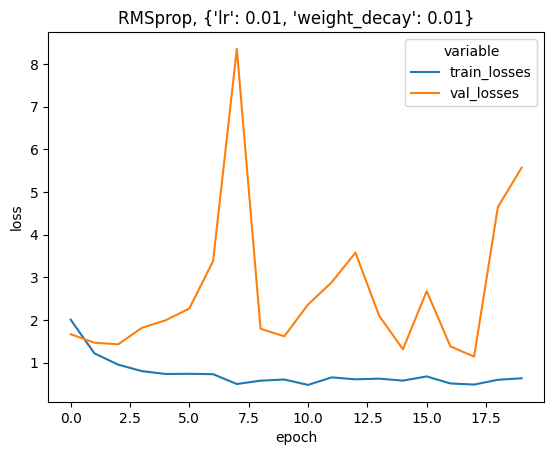

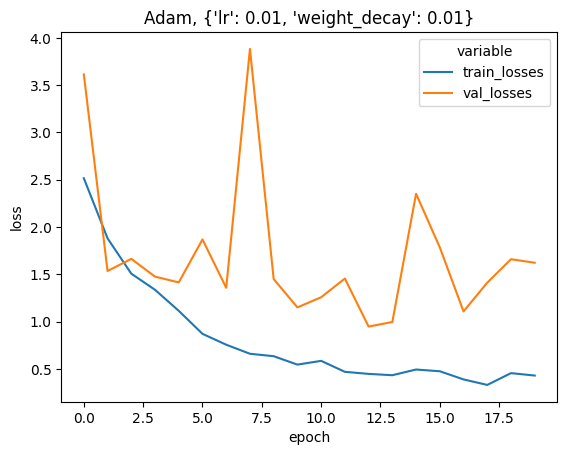

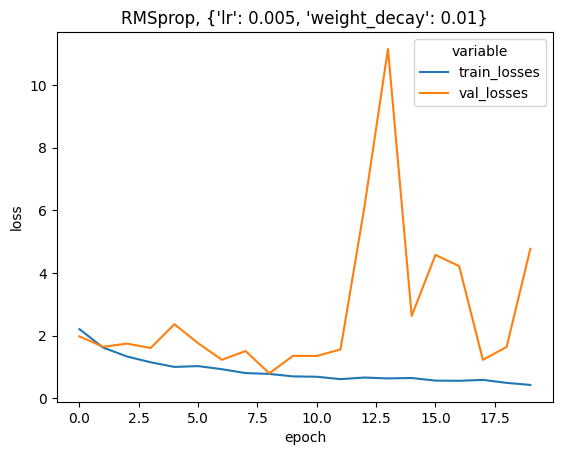

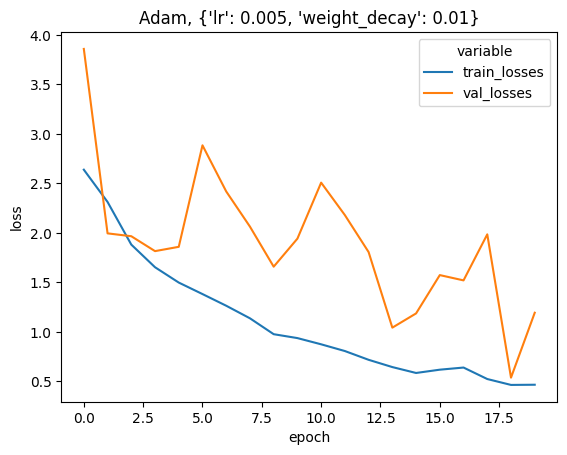

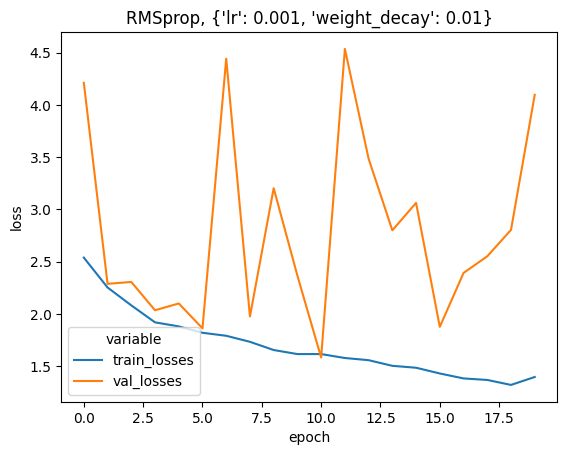

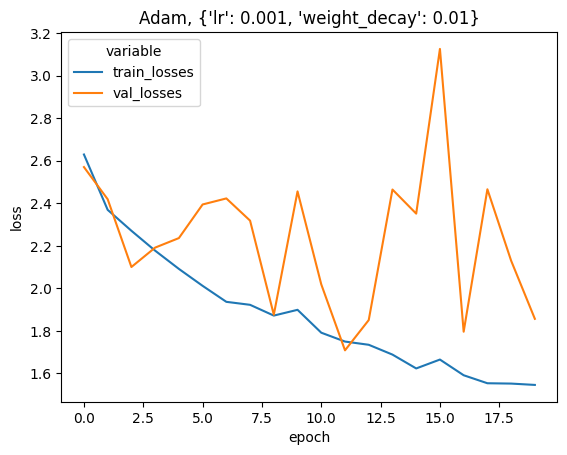

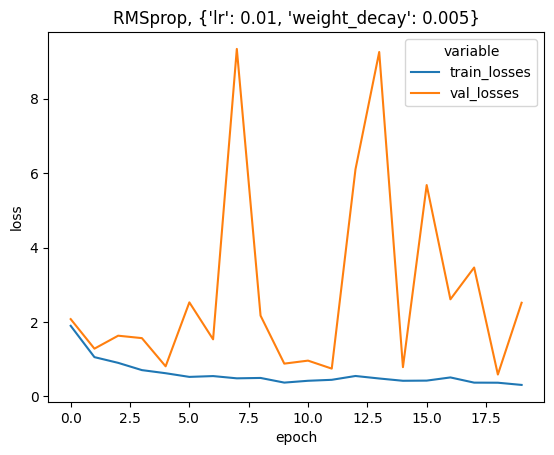

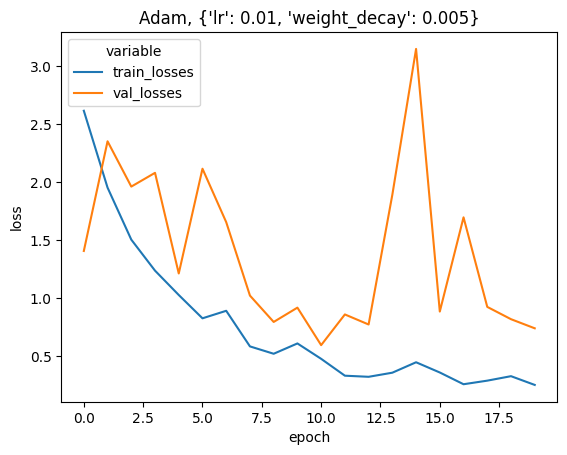

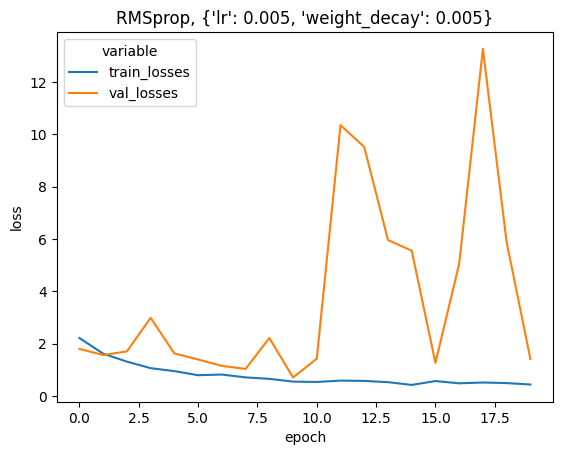

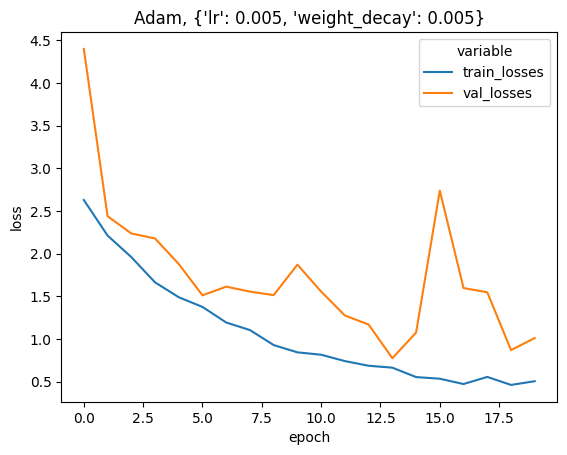

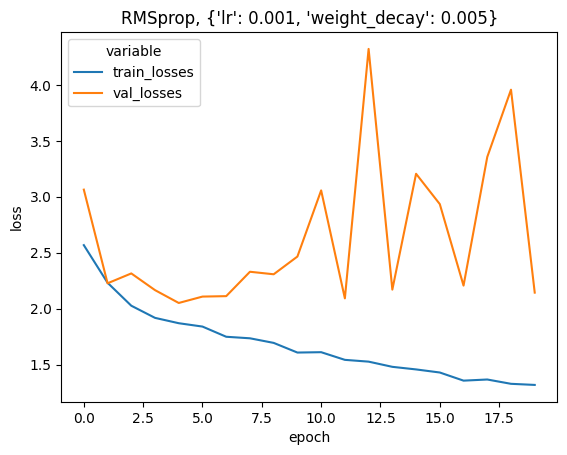

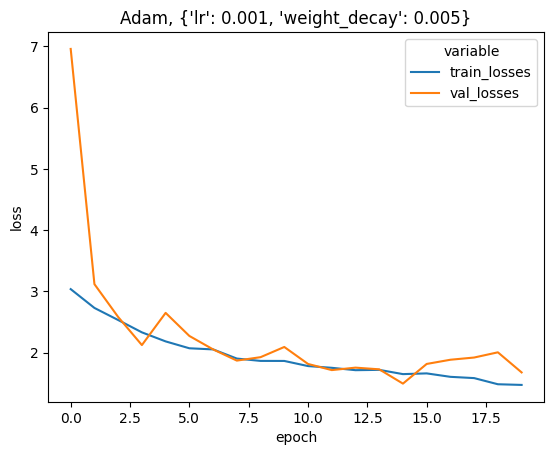

In [51]:
plot_train_val_losses(df, bn_results)

In [56]:
df.drop_duplicates(subset=['idx'])[['test_accuracy', 'optimizer', 'params.lr', 'params.weight_decay']].sort_values(by='test_accuracy', ascending=False)

,test_accuracy,optimizer,params.lr,params.weight_decay
0,0.951220,Adam,0.010,0.005
0,0.902439,Adam,0.001,0.010
0,0.804878,Adam,0.005,0.005
0,0.804878,Adam,0.001,0.005
0,0.780488,Adam,0.010,0.010
0,0.707317,Adam,0.005,0.010
0,0.682927,RMSprop,0.005,0.005
0,0.682927,RMSprop,0.010,0.005
0,0.585366,RMSprop,0.001,0.005
0,0.512195,RMSprop,0.005,0.010


Точность всех моделей можно видеть в представленных таблицах. Как видим, результаты с использованием batch normalization только ухудшились